<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/Plots_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#@title Github
%%capture

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI

import sys
!{sys.executable} -m pip install ipympl

In [144]:
!ls "MD-SCPI/PDBs/MC/AS4/9600K"

MR-AS4_10_MR-AS4.inpcrd_mc.dat.gz  MR-AS4_5_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_6_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_2_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_7_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_3_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_8_MR-AS4.inpcrd_mc.dat.gz
MR-AS4_4_MR-AS4.inpcrd_mc.dat.gz   MR-AS4_9_MR-AS4.inpcrd_mc.dat.gz


In [145]:
import gzip
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from google.colab import output
import numpy as np
import matplotlib as mpl
from scipy.stats import linregress
import matplotlib.cm as cm
from matplotlib import gridspec

def ReadGz(path):
  #data = pd.read_csv(path, compression='gzip',  header=4, delimiter="  ")[['#', 'Step', 'Unnamed: 6', 'Unnamed: 7', ' RMSD']].rename({'#':'Step', 'Step':'Energy', 'Unnamed: 6':'RMSD', 'Unnamed: 7':'DX', ' RMSD':'DY'}, axis=1)
  file1 = gzip.open(path)
  a = file1.read()

  array, c = [], 0
  text = str(a).split()[11:]
  head = text[:14] # 20 

  for i in range(20,len(text)):
    c += 1
    if '\\n' in text[i]:
      text[i] = text[i].replace("\\n","")
      text[i] = text[i].replace("'","")
      words = [float(word) for word in text[i-c+1:i+1]]
      array.append(words) #text[i-c+1:i+1])
      c = 0

  array = np.array(array)
  data = pd.DataFrame({head[i]:array[:,i] for i in range(len(head))})
  return data

%matplotlib ipympl
output.enable_custom_widget_manager()

In [146]:
#file1 = gzip.open('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')
#ReadGz('MD-SCPI/PDBs/MC/AS4/300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz')['Step']

In [158]:
temperatures = ['300K', '600K', '1200K', '2400K', '4800K', '9600K']
high_temperatures = ['10000K', '15000K', '20000K']
colors = ['gray', 'violet', 'red', 'green', 'orange', 'blue']
N, N_high = 10, 31
unit, unit2 = np.linspace(0.1, 0.9, N), np.linspace(0.9, 0.2, N)
unit_high, unit2_high = np.linspace(0.1, 0.9, N_high), np.linspace(0.9, 0.2, N_high)
Colors = [cm.Greys(unit), cm.Purples(unit), cm.Reds(unit), cm.Greens(unit), cm.Oranges(unit), cm.Blues(unit)]
Colors_high = [cm.Greys(unit_high), cm.Purples(unit_high), cm.Reds(unit_high), cm.Greens(unit_high), cm.Oranges(unit_high), cm.Blues(unit_high)]
path = 'MD-SCPI/PDBs/MC/AS4/' #300K/MR-AS4_1_MR-AS4.inpcrd_mc.dat.gz'

parameters, high_parameters = pd.DataFrame(), pd.DataFrame()

for j in range(6):
  for i in range(N_high): Colors_high[j][i][-1]=unit2_high[i]
  for k in range(N):      Colors[j][k][-1]=unit2[k]

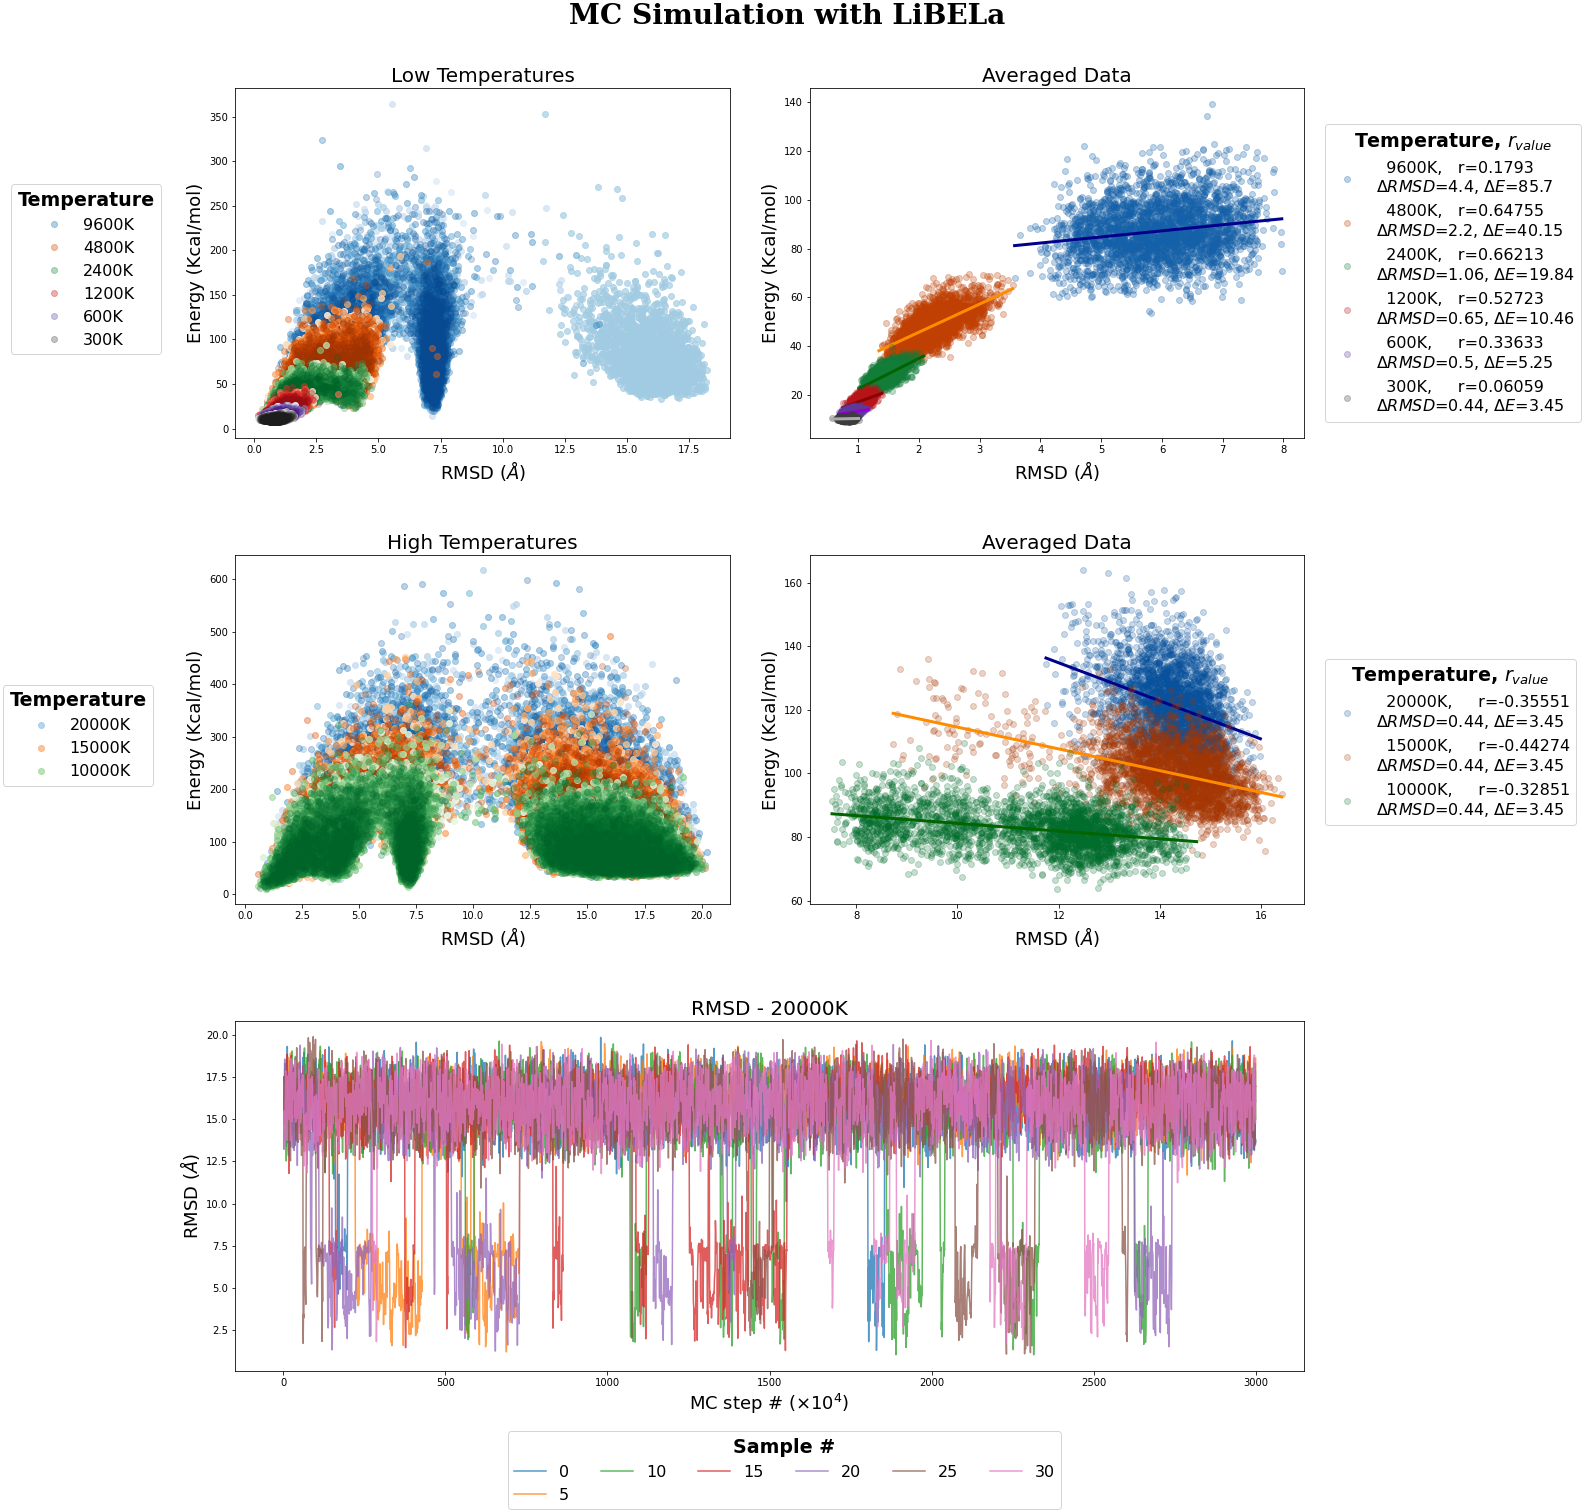

In [185]:
plt.close()

#fig, axs = plt.subplots(3,2,figsize=(20,21), gridspec_kw={'hspace': 0.3})
fig = plt.figure(layout="constrained", figsize=(22,21)) # tight_layout=True
gs = gridspec.GridSpec(3, 2, hspace=0.1, figure=fig)

N_plot = 5     # is used to plot, number of plots is N_samples%N_plot 
RMSD_temp = '20000K'
ax = fig.add_subplot(gs[2, :])
axs = np.array([[fig.add_subplot(gs[0,0]),fig.add_subplot(gs[0,1])],  [fig.add_subplot(gs[1,0]),fig.add_subplot(gs[1,1])]])

c=0
for i in range(len(temperatures)-1,-1,-1): #list(reversed((temperatures))):
  rmsd, energy = [], []
  gz_files = [f for f in listdir(path+temperatures[i]) if isfile(join(path+temperatures[i], f)) and (('mol2' not in f) and ('.gitignore' not in f))]
  for j in range(len(gz_files)):
    data = ReadGz(path+temperatures[i]+'/'+gz_files[j])
    rmsd.append(data['RMSD']); energy.append(data['Energy'])
    if j==7:   axs[0,0].plot(data['RMSD'], data['Energy'], 'o', label=temperatures[i], color=Colors[i][j]) #colors[i], alpha=1-0.15*i)
    else:      axs[0,0].plot(data['RMSD'], data['Energy'], 'o',  color=Colors[i][j])

    rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
    slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])
    # axs[0].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)

    value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                        'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                        'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
    parameters = pd.concat([parameters, value], ignore_index=True)
    c += 1
  
    # -------- remove repeated legend labels -------------
    # handles, labels = plt.gca().get_legend_handles_labels()
    # by_label = dict(zip(labels, handles))
    # plt.legend(by_label.values(), by_label.keys())
  
  # -------- average ------------------
  rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
  slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)
  rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
  if len(temperatures[i]) == 4:
           label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  axs[0,1].plot(rmsd, energy, 'o', label=label, color=Colors[i][j-1])#colors[i], alpha=0.5)
  axs[0,1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
  
#######################################################################################
# --------------------------------- high temperatures --------------------------------------------
c=0
for i in range(len(high_temperatures)-1,-1,-1): #list(reversed((temperatures))):
  high_rmsd, high_energy = [], []
  gz_files = [f for f in listdir(path+high_temperatures[i]) if isfile(join(path+high_temperatures[i], f)) and (('mol2' not in f) and ('gitignore' not in f))]
  for j in range(len(gz_files)):
    data = ReadGz(path+high_temperatures[i]+'/'+gz_files[j])
    high_rmsd.append(data['RMSD']); high_energy.append(data['Energy'])
    if j==12: axs[1,0].plot(data['RMSD'], data['Energy'], 'o', label=high_temperatures[i], color=Colors_high[i+3][j])
    else:     axs[1,0].plot(data['RMSD'], data['Energy'], 'o', color=Colors_high[i+3][j])

    rmsd_array = np.linspace(min(data['RMSD']), max(data['RMSD']), 1000)
    slope, intercept, r_value, p_value, std_err = linregress(data['RMSD'], data['Energy'])

    value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
                        'p_value':p_value, 'std_err':std_err, #'deltaE':float(max(energy)-min(energy)), 'deltaRMSD':float(max(rmsd)-min(rmsd)),
                        'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[c])
    high_parameters = pd.concat([high_parameters, value], ignore_index=True)

    c += 1

    if high_temperatures[i]==RMSD_temp and j%N_plot==0: 
      ax.plot(1+data.index, data['RMSD'], '-', label=str(j), alpha=0.75, ms=3) # , color=Colors_high[i+3][j]
  # -------- average ------------------
  high_rmsd = np.average(np.array(high_rmsd), axis=0); high_energy = np.average(np.array(high_energy), axis=0)
  slope, intercept, r_value, p_value, std_err = linregress(high_rmsd, high_energy)
  rmsd_array = np.linspace(min(high_rmsd), max(high_rmsd), 1000)
  #if len(temperatures[i]) == 4:
  label = '  '+high_temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  #else:    label = '  '+high_temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  axs[1,1].plot(high_rmsd, high_energy, 'o', label=label, color=Colors_high[i+3][j-1])#colors[i], alpha=0.5)
  axs[1,1].plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i+3], lw=3)

# ----------- legends, labels and titles for each axis ----------------
axs[0,0].set_ylabel('Energy (Kcal/mol)', fontsize='18'); axs[0,0].set_xlabel('RMSD ($\AA$)', fontsize='18'); 
axs[0,0].legend(title='Temperature', bbox_to_anchor=(-.15, .725), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'}, borderaxespad=0.)
axs[0,0].set_title('Low Temperatures', fontsize='20', fontweight='normal')
#plt.ylim((0, 100)); plt.xlim((0, 10))

#axs[1].sharex(axs[0,0])
axs[0,1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[0,1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
axs[0,1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, 0.92), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
axs[0,1].set_title('Averaged Data', fontsize='20', fontweight='normal')

axs[1,0].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1,0].set_ylabel('Energy (Kcal/mol)', fontsize='18')
axs[1,0].legend(title='Temperature', bbox_to_anchor=(-.15, .65), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
axs[1,0].set_title('High Temperatures', fontsize='20', fontweight='normal')

axs[1,1].set_xlabel('RMSD ($\AA$)', fontsize='18'); axs[1,1].set_ylabel('Energy (Kcal/mol)', fontsize='18')
axs[1,1].legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, 0.725), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
axs[1,1].set_title('Averaged Data', fontsize='20', fontweight='normal')

ax.set_ylabel('RMSD ($\AA$)', fontsize='18'); ax.set_xlabel(r'MC step # ($\times 10^4$)', fontsize='18')
ax.legend(title='Sample #', bbox_to_anchor=(.78, -0.15), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'}, ncol=6) #N//N_plot
ax.set_title('RMSD - '+RMSD_temp, fontsize='20', fontweight='normal')


plt.suptitle('MC Simulation with LiBELa \n', fontsize='28', fontweight='bold', x=0.5,  fontfamily='serif')
fig.savefig("./MC_energies.png", transparent=True)#, bbox_inches='tight')

In [172]:
data

,Step,Energy,RMSD,DX,DY,DZ,ALPHA,BETA,GAMMA,NCONF,ConfEnergy,Elec,VDW,SOLV
0,10000.0,67.306,7.126,36.011001,63.650857,39.442749,177.575580,71.293344,1.947892,0.0,55.064,-0.567876,5.306557,7.503403
1,20000.0,185.933,6.513,35.164496,63.524789,41.728556,89.749943,17.362325,64.016134,0.0,66.536,-1.501419,113.047898,7.850503
2,30000.0,92.763,7.121,34.875912,64.419446,41.033958,96.787252,36.296556,146.458271,0.0,66.178,-1.453276,20.643465,7.394079
3,40000.0,111.564,6.654,36.247564,63.657282,40.186944,70.399269,63.023471,180.424650,0.0,65.257,-1.664649,40.685679,7.285031
4,50000.0,93.040,7.336,35.522654,61.713789,39.385115,32.147143,52.533515,183.268882,0.0,73.079,-3.115805,14.259539,8.816717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,29960000.0,124.240,15.240,43.202192,73.807593,45.183281,210.076358,171.730908,314.809278,0.0,64.353,3.097943,50.684523,6.104529
2996,29970000.0,123.927,15.157,42.416357,73.607286,45.898447,248.330626,3.151526,87.109196,0.0,65.359,0.790411,52.165653,5.611823
2997,29980000.0,56.536,17.397,44.262373,74.871069,48.015659,168.518528,159.320421,355.256830,0.0,63.835,-3.183962,-7.875047,3.760025
2998,29990000.0,95.476,14.650,46.905360,65.329232,49.340581,184.946694,105.373030,40.997212,0.0,66.368,3.555508,18.520055,7.032469


In [153]:
parameters.head()

,temperature,slope,intercept,r_value,p_value,std_err,E_mean,RMSD_mean
0,9600K,3.799543,68.758328,0.227778,1.316782e-36,0.296643,87.210101,4.856314
1,9600K,2.770714,74.310722,0.154264,1.949528e-17,0.324102,88.023703,5.049608
2,9600K,3.483445,69.269940,0.209201,5.084069e-31,0.297380,87.904365,5.126708
3,9600K,-0.594173,92.285054,-0.091236,5.570526e-07,0.118445,87.069781,7.092834
4,9600K,3.584968,71.198456,0.202779,3.298446e-29,0.316176,87.504540,6.680978


In [154]:
high_parameters.head()

,temperature,slope,intercept,r_value,p_value,std_err,E_mean,RMSD_mean
0,1200K,-8.094530,238.962705,-0.334135,3.703433e-79,0.417010,10.240653,0.818284
1,1200K,-6.634840,216.806037,-0.360067,1.616823e-92,0.313963,10.240653,0.818284
2,1200K,-5.209953,196.663515,-0.352731,1.309437e-88,0.252419,10.240653,0.818284
3,1200K,-6.401936,215.849036,-0.351914,3.515288e-88,0.310992,10.240653,0.818284
4,1200K,-5.605740,201.984871,-0.359816,2.208350e-92,0.265478,10.240653,0.818284


In [ ]:
# plt.close()
# fig = plt.figure(figsize=(12,7))

# parameters = pd.DataFrame()

# for i in range(len(temperatures)-1,-1,-1):#list(reversed((temperatures))):
#   rmsd, energy = [], []
#   for file in gz_files:
#     data = ReadGz(path+temperatures[i]+'/'+file)
#     rmsd.append(data['RMSD']); energy.append(data['Energy'])
#     #plt.plot(data['RMSD'], data['Energy'], 'o', label=temp)
  
#   rmsd = np.average(np.array(rmsd), axis=0); energy = np.average(np.array(energy), axis=0)
#   slope, intercept, r_value, p_value, std_err = linregress(rmsd, energy)

#   value = pd.DataFrame({'temperature':temperatures[i],'slope':slope, 'intercept':intercept, 'r_value':r_value, 
#                         'p_value':p_value, 'std_err':std_err, 'deltaE':max(energy)-min(energy), 'deltaRMSD':max(rmsd)-min(rmsd),
#                         'E_mean':np.mean(energy), 'RMSD_mean':np.mean(rmsd)}, index=[i])
#   parameters = pd.concat([parameters, value], ignore_index=True)

#   rmsd_array = np.linspace(min(rmsd), max(rmsd), 1000)
#   if len(temperatures[i]) == 4:
#            label = '  '+temperatures[i]+',     r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
#   else:    label = '  '+temperatures[i]+',   r={}\n$\Delta RMSD$={}, $\Delta E$={}'.format(round(r_value,5), round(max(rmsd)-min(rmsd),2), round(max(energy)-min(energy),2))
  
#   plt.plot(rmsd, energy, 'o', label=label, color=colors[i], alpha=0.5)
#   plt.plot(rmsd_array, slope*rmsd_array+intercept, color='dark'+colors[i], lw=3)
  
# plt.xlabel('RMSD ($\AA$)', fontsize='18'); plt.ylabel('Energy (Kcal/mol)', fontsize='18')
# plt.legend(title='Temperature, $r_{value}$', bbox_to_anchor=(1.025, .85), fontsize='16', title_fontproperties={'weight':'bold', 'size':'19'})
# plt.title('Average MC Data', fontsize='20', fontweight='bold')
# #plt.ylim((0, 100)); plt.xlim((0, 10))


# fig.tight_layout()

In [ ]:
parameters

,temperature,slope,intercept,r_value,p_value,std_err,deltaE,deltaRMSD,E_mean,RMSD_mean
0,9600K,3.618476,68.128719,0.189429,1.237636e-25,0.342554,88.1144,4.0729,86.377283,5.043162
1,4800K,7.686823,25.420495,0.489727,9.033058e-181,0.249937,39.4214,2.3833,48.524411,3.005652
2,2400K,11.422871,11.276015,0.616388,1.728381e-313,0.266517,21.2101,1.2229,27.205981,1.394568
3,1200K,10.020911,7.149810,0.572122,1.938263e-260,0.262365,10.4608,0.6064,17.830673,1.065857
4,600K,3.986522,9.410569,0.359297,4.207386e-92,0.189108,5.8456,0.5102,12.935471,0.884205
5,300K,0.883189,9.500466,0.105896,6.096991e-09,0.151465,3.0744,0.4169,10.224093,0.819335
